GAN（Generative Adversarial Network）是一种深度学习模型，由加拿大蒙特利尔大学的Ian Goodfellow等人在2014年提出。GAN由两个神经网络组成，一个生成器网络和一个判别器网络，二者相互博弈、相互竞争，最终达到生成逼真的数据的目的。

生成器网络的作用是输入一个随机噪声向量，生成一个与真实数据相似的样本。判别器网络的作用是将生成器生成的样本与真实数据进行区分。随着训练的进行，生成器不断调整自己的生成策略，使得生成的样本更接近真实数据；而判别器也不断调整自己的判别策略，使得能够更准确地区分生成的样本和真实数据。当生成器生成的样本足够真实，判别器无法区分时，GAN的训练就完成了。

GAN的优点在于可以生成高质量的数据，不需要任何先验知识，只需要输入一些噪声即可。

![](https://raw.githubusercontent.com/xuehangcang/DeepLearning/main/static/GAN.png)

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import torchvision.utils as vutils

In [4]:
training_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=transforms.ToTensor(),
)

In [5]:
batch_size = 64
train_dataloader = DataLoader(training_data, batch_size=batch_size, shuffle=True)

In [6]:
device = "cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu"
print(device)

mps


## 1.Generator 生成器

In [7]:
class GANGenerator(nn.Module):
    """GAN生成器模型"""
    def __init__(self, input_size: int, output_size: int, hidden_size: int):
        """

        :param input_size: 输入向量的维度
        :param output_size: 输出向量的维度
        :param hidden_size: 隐藏层的维度
        """
        super(GANGenerator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, output_size),
            nn.Tanh()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

## 2.Discriminator 判别器

In [8]:
class GANDiscriminator(nn.Module):
    """GAN判别器模型"""
    def __init__(self, input_size: int, hidden_size: int):
        """

        :param input_size: 输入向量的维度
        :param hidden_size: 隐藏层的维度
        """
        super(GANDiscriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Linear(input_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Linear(hidden_size, 1),
            nn.Sigmoid()
        )

    def forward(self, x: torch.Tensor) -> torch.Tensor:
        x = self.model(x)
        return x

In [9]:
generator = GANGenerator(100, 784, 256).to(device)
discriminator = GANDiscriminator(784, 256).to(device)

In [10]:
# 定义损失函数和优化器
criterion = nn.BCELoss()
optimizer_g = optim.Adam(generator.parameters(), lr=0.0002)
optimizer_d = optim.Adam(discriminator.parameters(), lr=0.0002)

In [11]:
def save_samples(generator, device, n_samples=64):
    """保存生成的样本"""
    z = torch.randn(n_samples, 100).to(device)
    samples = generator(z)
    samples = samples.view(n_samples, 1, 28, 28).cpu().detach()
    grid = vutils.make_grid(samples, normalize=True, nrow=8)
    plt.imshow(grid.permute(1, 2, 0))
    plt.axis("off")
    plt.show()

In [12]:
def train_gan(generator, discriminator, train_dataloader, criterion, optimizer_g, optimizer_d, device, n_epochs):
    for epoch in range(n_epochs):
        for i, data in enumerate(train_dataloader):
            real_data, _ = data
            batch_size = real_data.size(0)

            # 训练判别器
            real_data = real_data.view(batch_size, -1).to(device)
            label_real = torch.ones(batch_size, 1).to(device)
            label_fake = torch.zeros(batch_size, 1).to(device)

            z = torch.randn(batch_size, 100).to(device)
            fake_data = generator(z)

            optimizer_d.zero_grad()
            output_real = discriminator(real_data)
            loss_real = criterion(output_real, label_real)
            loss_real.backward()

            output_fake = discriminator(fake_data.detach())
            loss_fake = criterion(output_fake, label_fake)
            loss_fake.backward()

            loss_d = loss_real + loss_fake
            optimizer_d.step()

            # 训练生成器
            z = torch.randn(batch_size, 100).to(device)
            fake_data = generator(z)

            optimizer_g.zero_grad()
            output_g = discriminator(fake_data)
            loss_g = criterion(output_g, label_real)
            loss_g.backward()

            optimizer_g.step()

            if i % 100 == 0:
                print("[Epoch %d/%d] [Batch %d/%d] [D loss: %f] [G loss: %f]" % (
                    epoch, n_epochs, i, len(train_dataloader), loss_d.item(), loss_g.item()))
        save_samples(generator, device)

[Epoch 0/10] [Batch 0/938] [D loss: 1.388967] [G loss: 0.716558]
[Epoch 0/10] [Batch 100/938] [D loss: 0.423460] [G loss: 2.054379]
[Epoch 0/10] [Batch 200/938] [D loss: 0.165438] [G loss: 3.270552]
[Epoch 0/10] [Batch 300/938] [D loss: 0.340016] [G loss: 3.858542]
[Epoch 0/10] [Batch 400/938] [D loss: 0.190159] [G loss: 3.853421]
[Epoch 0/10] [Batch 500/938] [D loss: 0.158236] [G loss: 3.916997]
[Epoch 0/10] [Batch 600/938] [D loss: 0.387926] [G loss: 2.327542]
[Epoch 0/10] [Batch 700/938] [D loss: 0.162256] [G loss: 3.074591]
[Epoch 0/10] [Batch 800/938] [D loss: 0.403764] [G loss: 2.083531]
[Epoch 0/10] [Batch 900/938] [D loss: 0.386691] [G loss: 2.243037]


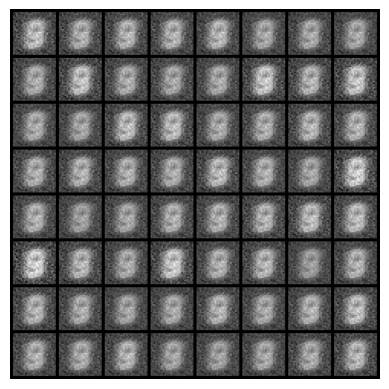

[Epoch 1/10] [Batch 0/938] [D loss: 0.371274] [G loss: 2.067755]
[Epoch 1/10] [Batch 100/938] [D loss: 0.169419] [G loss: 3.157981]
[Epoch 1/10] [Batch 200/938] [D loss: 0.442311] [G loss: 2.210665]
[Epoch 1/10] [Batch 300/938] [D loss: 0.151942] [G loss: 3.897982]
[Epoch 1/10] [Batch 400/938] [D loss: 0.191554] [G loss: 3.416059]
[Epoch 1/10] [Batch 500/938] [D loss: 0.141283] [G loss: 3.700531]
[Epoch 1/10] [Batch 600/938] [D loss: 0.220104] [G loss: 4.394159]
[Epoch 1/10] [Batch 700/938] [D loss: 0.255653] [G loss: 6.412407]
[Epoch 1/10] [Batch 800/938] [D loss: 0.582087] [G loss: 2.493481]
[Epoch 1/10] [Batch 900/938] [D loss: 0.093355] [G loss: 3.496910]


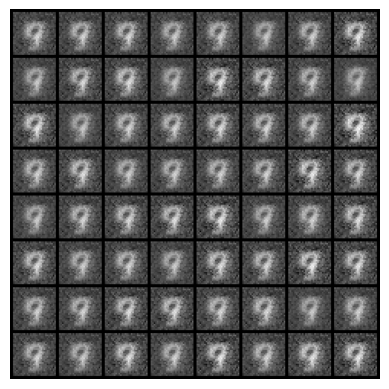

[Epoch 2/10] [Batch 0/938] [D loss: 0.268160] [G loss: 4.293471]
[Epoch 2/10] [Batch 100/938] [D loss: 0.396424] [G loss: 4.078848]
[Epoch 2/10] [Batch 200/938] [D loss: 0.096118] [G loss: 3.747328]
[Epoch 2/10] [Batch 300/938] [D loss: 0.154628] [G loss: 4.289879]
[Epoch 2/10] [Batch 400/938] [D loss: 0.158361] [G loss: 5.553900]
[Epoch 2/10] [Batch 500/938] [D loss: 0.068309] [G loss: 5.745209]
[Epoch 2/10] [Batch 600/938] [D loss: 0.058456] [G loss: 4.720566]
[Epoch 2/10] [Batch 700/938] [D loss: 0.178346] [G loss: 4.624626]
[Epoch 2/10] [Batch 800/938] [D loss: 0.241546] [G loss: 4.215399]
[Epoch 2/10] [Batch 900/938] [D loss: 0.126405] [G loss: 4.878530]


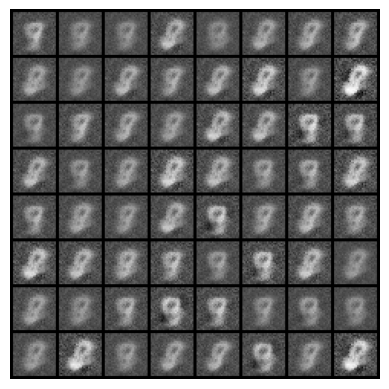

[Epoch 3/10] [Batch 0/938] [D loss: 0.174728] [G loss: 4.075701]
[Epoch 3/10] [Batch 100/938] [D loss: 0.158311] [G loss: 4.631653]
[Epoch 3/10] [Batch 200/938] [D loss: 0.188642] [G loss: 4.115180]
[Epoch 3/10] [Batch 300/938] [D loss: 0.080734] [G loss: 4.917578]
[Epoch 3/10] [Batch 400/938] [D loss: 0.046135] [G loss: 4.767245]
[Epoch 3/10] [Batch 500/938] [D loss: 0.241083] [G loss: 5.628273]
[Epoch 3/10] [Batch 600/938] [D loss: 0.131688] [G loss: 4.808406]
[Epoch 3/10] [Batch 700/938] [D loss: 0.123871] [G loss: 4.216973]
[Epoch 3/10] [Batch 800/938] [D loss: 0.079691] [G loss: 6.090776]
[Epoch 3/10] [Batch 900/938] [D loss: 0.081176] [G loss: 4.960333]


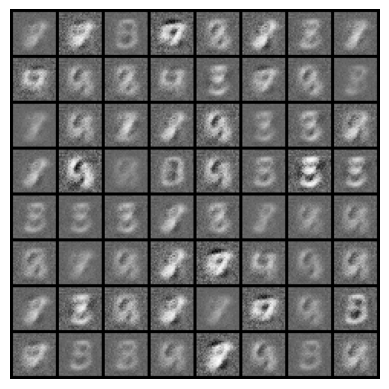

[Epoch 4/10] [Batch 0/938] [D loss: 0.284532] [G loss: 5.600065]
[Epoch 4/10] [Batch 100/938] [D loss: 0.071020] [G loss: 4.819930]
[Epoch 4/10] [Batch 200/938] [D loss: 0.144015] [G loss: 5.606718]
[Epoch 4/10] [Batch 300/938] [D loss: 0.313523] [G loss: 5.203820]
[Epoch 4/10] [Batch 400/938] [D loss: 0.292696] [G loss: 5.106553]
[Epoch 4/10] [Batch 500/938] [D loss: 0.065488] [G loss: 5.759413]
[Epoch 4/10] [Batch 600/938] [D loss: 0.044181] [G loss: 5.136661]
[Epoch 4/10] [Batch 700/938] [D loss: 0.224389] [G loss: 4.337078]
[Epoch 4/10] [Batch 800/938] [D loss: 0.155942] [G loss: 3.897457]
[Epoch 4/10] [Batch 900/938] [D loss: 0.081090] [G loss: 4.997708]


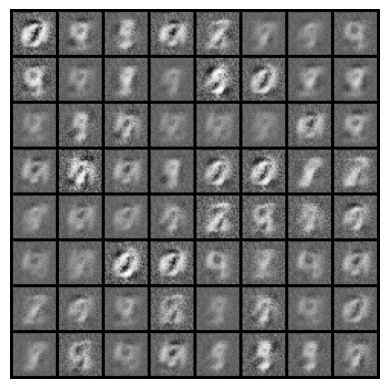

[Epoch 5/10] [Batch 0/938] [D loss: 0.231658] [G loss: 4.620449]
[Epoch 5/10] [Batch 100/938] [D loss: 0.176405] [G loss: 5.561572]
[Epoch 5/10] [Batch 200/938] [D loss: 0.246288] [G loss: 4.509353]
[Epoch 5/10] [Batch 300/938] [D loss: 0.124580] [G loss: 4.770920]
[Epoch 5/10] [Batch 400/938] [D loss: 0.194944] [G loss: 4.516924]
[Epoch 5/10] [Batch 500/938] [D loss: 0.091031] [G loss: 4.468251]
[Epoch 5/10] [Batch 600/938] [D loss: 0.103967] [G loss: 4.659425]
[Epoch 5/10] [Batch 700/938] [D loss: 0.117286] [G loss: 4.327636]
[Epoch 5/10] [Batch 800/938] [D loss: 0.187449] [G loss: 5.577556]
[Epoch 5/10] [Batch 900/938] [D loss: 0.156961] [G loss: 5.721947]


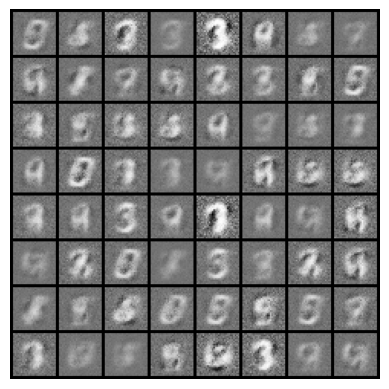

[Epoch 6/10] [Batch 0/938] [D loss: 0.173011] [G loss: 5.104124]
[Epoch 6/10] [Batch 100/938] [D loss: 0.129039] [G loss: 5.691098]
[Epoch 6/10] [Batch 200/938] [D loss: 0.152430] [G loss: 5.690816]
[Epoch 6/10] [Batch 300/938] [D loss: 0.060898] [G loss: 5.024020]
[Epoch 6/10] [Batch 400/938] [D loss: 0.081648] [G loss: 6.216514]
[Epoch 6/10] [Batch 500/938] [D loss: 0.152357] [G loss: 5.812562]
[Epoch 6/10] [Batch 600/938] [D loss: 0.061671] [G loss: 5.711820]
[Epoch 6/10] [Batch 700/938] [D loss: 0.181755] [G loss: 4.925428]
[Epoch 6/10] [Batch 800/938] [D loss: 0.147885] [G loss: 5.374728]
[Epoch 6/10] [Batch 900/938] [D loss: 0.137331] [G loss: 4.689366]


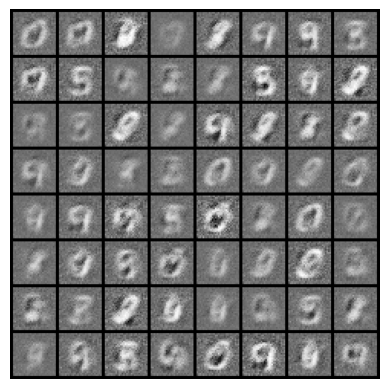

[Epoch 7/10] [Batch 0/938] [D loss: 0.056303] [G loss: 5.126579]
[Epoch 7/10] [Batch 100/938] [D loss: 0.098021] [G loss: 5.096084]
[Epoch 7/10] [Batch 200/938] [D loss: 0.089294] [G loss: 5.499576]
[Epoch 7/10] [Batch 300/938] [D loss: 0.130256] [G loss: 5.834646]
[Epoch 7/10] [Batch 400/938] [D loss: 0.295697] [G loss: 4.966979]
[Epoch 7/10] [Batch 500/938] [D loss: 0.095833] [G loss: 4.761473]
[Epoch 7/10] [Batch 600/938] [D loss: 0.119719] [G loss: 4.904280]
[Epoch 7/10] [Batch 700/938] [D loss: 0.039117] [G loss: 5.822599]
[Epoch 7/10] [Batch 800/938] [D loss: 0.111403] [G loss: 5.236696]
[Epoch 7/10] [Batch 900/938] [D loss: 0.150459] [G loss: 4.498529]


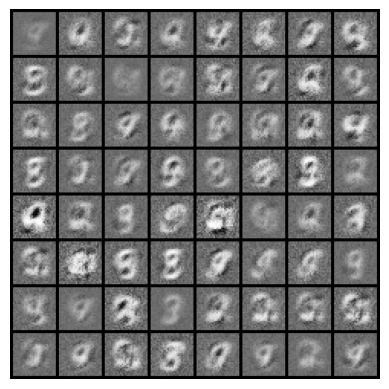

[Epoch 8/10] [Batch 0/938] [D loss: 0.152545] [G loss: 5.068021]
[Epoch 8/10] [Batch 100/938] [D loss: 0.123427] [G loss: 5.072657]
[Epoch 8/10] [Batch 200/938] [D loss: 0.257832] [G loss: 4.405077]
[Epoch 8/10] [Batch 300/938] [D loss: 0.217034] [G loss: 5.404679]
[Epoch 8/10] [Batch 400/938] [D loss: 0.218725] [G loss: 4.387761]
[Epoch 8/10] [Batch 500/938] [D loss: 0.260435] [G loss: 5.222061]
[Epoch 8/10] [Batch 600/938] [D loss: 0.228172] [G loss: 5.541053]
[Epoch 8/10] [Batch 700/938] [D loss: 0.142252] [G loss: 5.687625]
[Epoch 8/10] [Batch 800/938] [D loss: 0.145094] [G loss: 5.565855]
[Epoch 8/10] [Batch 900/938] [D loss: 0.376230] [G loss: 4.845890]


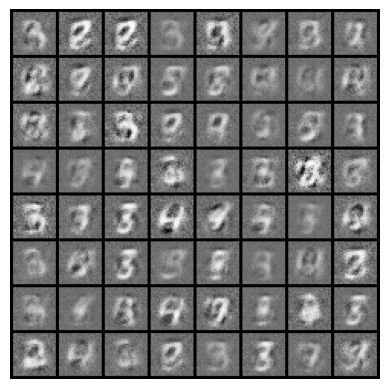

[Epoch 9/10] [Batch 0/938] [D loss: 0.253241] [G loss: 5.428637]
[Epoch 9/10] [Batch 100/938] [D loss: 0.105779] [G loss: 5.527081]
[Epoch 9/10] [Batch 200/938] [D loss: 0.060663] [G loss: 5.281925]
[Epoch 9/10] [Batch 300/938] [D loss: 0.096853] [G loss: 6.829427]
[Epoch 9/10] [Batch 400/938] [D loss: 0.192591] [G loss: 5.481013]
[Epoch 9/10] [Batch 500/938] [D loss: 0.264998] [G loss: 4.546735]
[Epoch 9/10] [Batch 600/938] [D loss: 0.075636] [G loss: 5.552195]
[Epoch 9/10] [Batch 700/938] [D loss: 0.145772] [G loss: 5.617272]
[Epoch 9/10] [Batch 800/938] [D loss: 0.229300] [G loss: 5.950866]
[Epoch 9/10] [Batch 900/938] [D loss: 0.152626] [G loss: 6.275063]


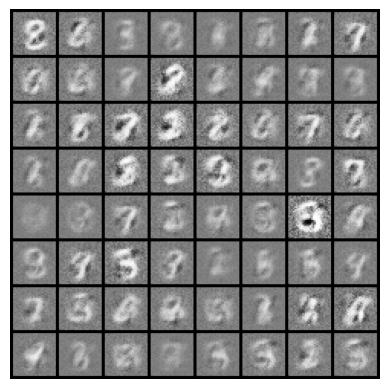

In [13]:
train_gan(generator, discriminator, train_dataloader, criterion, optimizer_g, optimizer_d, device, n_epochs=10)